In [1]:
using DifferentialEquations
using Plots
using SymPy

(-c/(2*sqrt(c^2 - 4*k*m)) + 1/2)*exp(-t*(c + sqrt(c^2 - 4*k*m))/(2*m)) + (c/(2*sqrt(c^2 - 4*k*m)) + 1/2)*exp(t*(-c + sqrt(c^2 - 4*k*m))/(2*m))


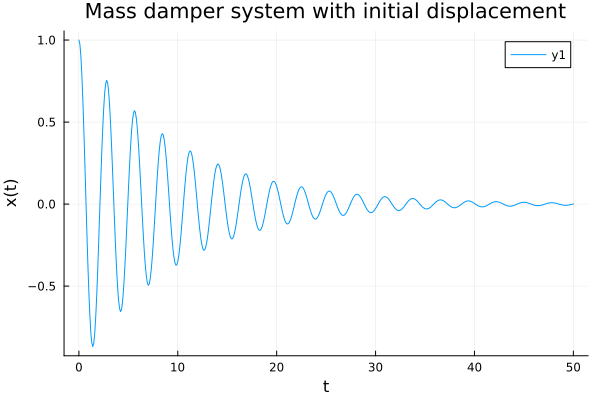

In [2]:
t = symbols("t")
x = SymFunction("x")(t)

m, c, k = symbols("m c k")

mass_damper = m * diff(x, t, 2) + c * diff(x, t) + k * x ~ 0

x_solution = dsolve(mass_damper, x)
x_general = rhs(x_solution)
x_prime = diff(x_general, t)

boundary_eq1 = x_general.subs(t,0) - 1
boundary_eq2 = x_prime.subs(t,0)

C1 = symbols("C1")
C2 = symbols("C2")
eqs = (boundary_eq1, boundary_eq2)
solution = solve([boundary_eq1, boundary_eq2], [C1, C2])
final_solution = x_general.subs(solution)


println(final_solution)

m_val = 1
c_val = 0.2
k_val = 5

numerical_solution = final_solution.subs((m => m_val, c => c_val, k => k_val))
t_domain = range(0, stop=50, length=500)

x_numeric = lambdify(numerical_solution, [t])

x_vals = x_numeric.(t_domain)

x_vals_plot = real(x_vals)

plot(t_domain, x_vals_plot, xlabel="t", ylabel="x(t)", title="Mass damper system with initial displacement", grid=true)

  3.289894 seconds (8.58 M allocations: 582.669 MiB, 15.22% gc time, 99.98% compilation time)
  0.000271 seconds (1.38 k allocations: 127.047 KiB)


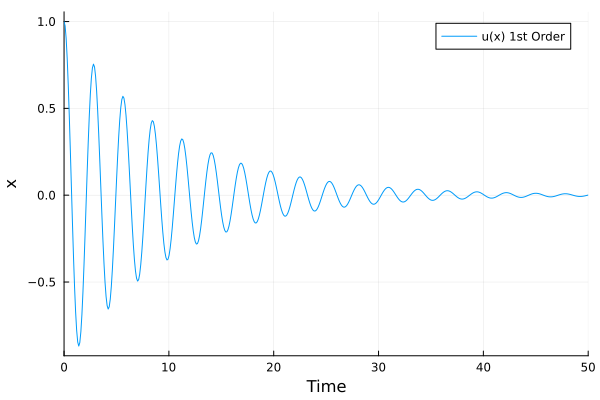

In [3]:
function mass_damper!(du, u, p, t)
    m, c, k = p
    du[1] = u[2]  
    du[2] = -(c/m) * u[2] - (k/m) * u[1]
end

m = 1.0
c = 0.2
k = 5.0
p = (m, c, k)

u0 = [1.0, 0.0]

tspan = (0.0, 50.0)
t_domain = range(0, stop=50, length=500)

prob = ODEProblem(mass_damper!, u0, tspan, p)

@time sol1 = solve(prob, Vern9(), saveat=t_domain)
@time sol1 = solve(prob, Vern9(), saveat=t_domain)

plot(sol1, idxs=1, label="u(x) 1st Order", xlabel="Time", ylabel="x")
#plot(sol1[1,:])

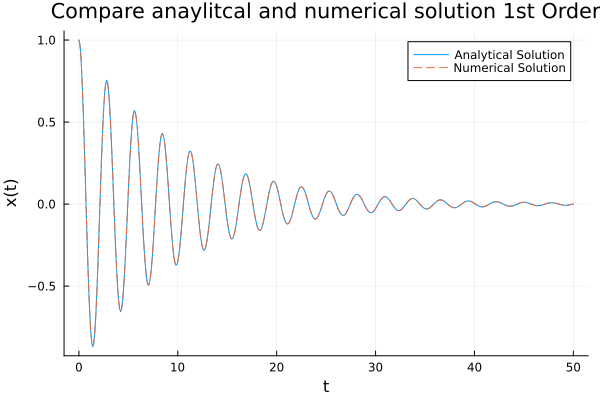

In [4]:
plot(t_domain, x_vals_plot, label="Analytical Solution", xlabel="t", ylabel="x(t)", title="Compare anaylitcal and numerical solution 1st Order", grid=true)
plot!(t_domain, sol1[1,:], label="Numerical Solution", linestyle=:dash)


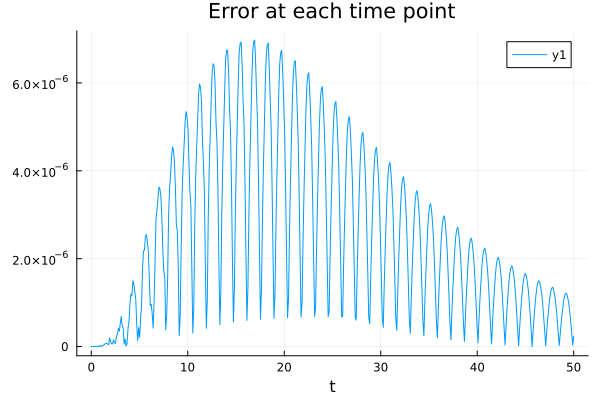

In [5]:
e1 = x_vals_plot - sol1[1,:]
plot(t_domain,abs.(e1), xlabel = "t", title = "Error at each time point")

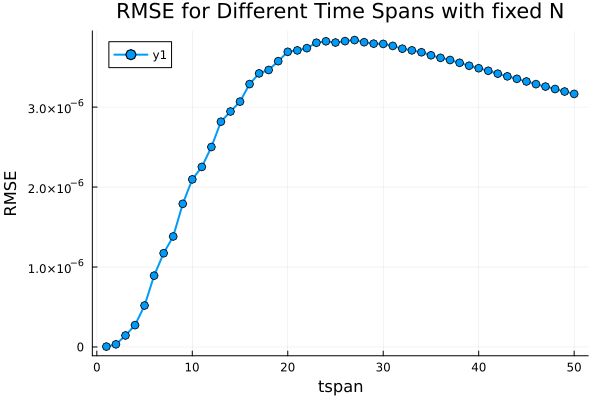

In [6]:
timeSpans = range(1,50,step = 1)
errors = Float64[]

for ts in timeSpans
    tspan = (0.0, ts)
    t_domain = range(0,stop = ts, length = 500)
    prob = ODEProblem(mass_damper!, u0, tspan, p)
    sol = solve(prob, Vern9(), saveat=t_domain)

    x_vals_analytical = [x_numeric(ti) for ti in t_domain]

    x_vals_numerical = sol[1,:]

    rmse = sqrt(sum((x_vals_analytical-x_vals_numerical).^2)/500)
    push!(errors, rmse)
end
plot(timeSpans, errors, xlabel="tspan", ylabel="RMSE", title="RMSE for Different Time Spans with fixed N", lw=2, marker=:o)


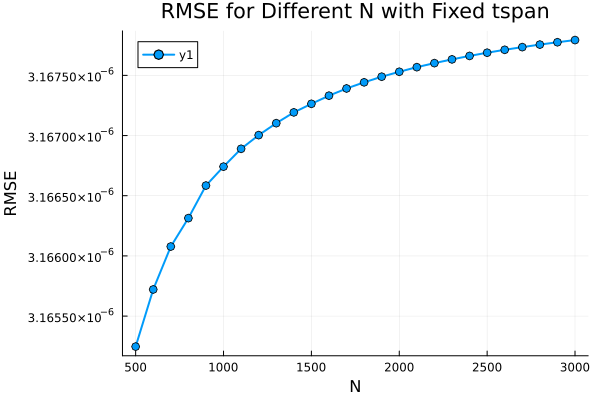

In [7]:
Nvals = range(500, 3000, step=100)
errors = Float64[]

for N in Nvals
    tspan = (0.0, 50.0)
    t_domain = range(0, stop=50, length=N)
    prob = ODEProblem(mass_damper!, u0, tspan, p)
    sol = solve(prob, Vern9(), saveat=t_domain)

    x_vals_analytical = [x_numeric(ti) for ti in t_domain]

    x_vals_numerical = sol[1,:]

    rmse = sqrt(sum((x_vals_analytical .- x_vals_numerical).^2) / N)
    push!(errors, rmse)
end

plot(Nvals, errors, xlabel="N", ylabel="RMSE", title="RMSE for Different N with Fixed tspan", lw=2, marker=:o)

In [8]:
function mass_damper2!(ddu, du, u, p, t)
    m, c, k = p
    ddu[1] = -(c/m) * du[1] - (k/m) * u[1]
end

mass_damper2! (generic function with 1 method)

 37.447558 seconds (131.55 M allocations: 7.547 GiB, 10.29% gc time, 100.00% compilation time)
  0.000752 seconds (3.92 k allocations: 240.359 KiB)


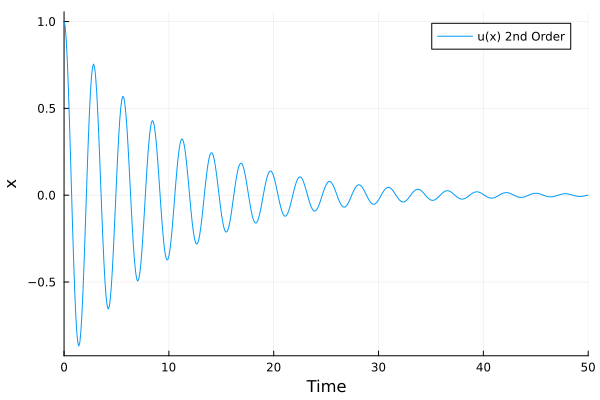

In [9]:
m = 1.0
c = 0.2
k = 5.0
p = (m, c, k)

u0 = [1.0, 0.0]  # u[1] = x, du[1] = v
du0 = [0.0]

tspan = (0.0, 50.0)
t_domain = range(0, stop=50, length=500)

prob = SecondOrderODEProblem(mass_damper2!, du0, u0, tspan, p)

@time sol2 = solve(prob, Vern9(), saveat=t_domain)
@time sol2 = solve(prob, Vern9(), saveat=t_domain)

plot(sol2, idxs=2, label="u(x) 2nd Order", xlabel="Time", ylabel="x")
#plot(sol2[2,:])

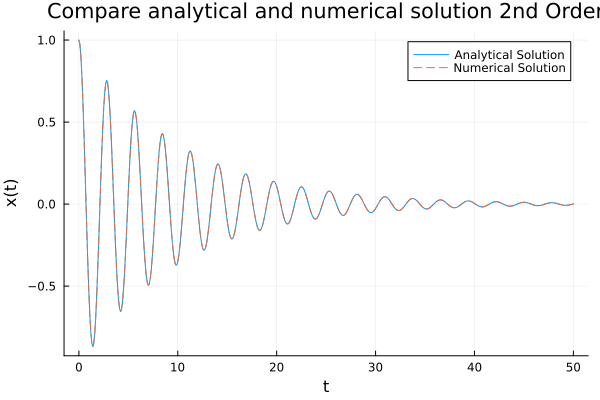

In [10]:
plot(t_domain, x_vals_plot, label="Analytical Solution", xlabel="t", ylabel="x(t)", title="Compare analytical and numerical solution 2nd Order", grid=true)
plot!(t_domain, sol2[2,:], label="Numerical Solution", linestyle=:dash)


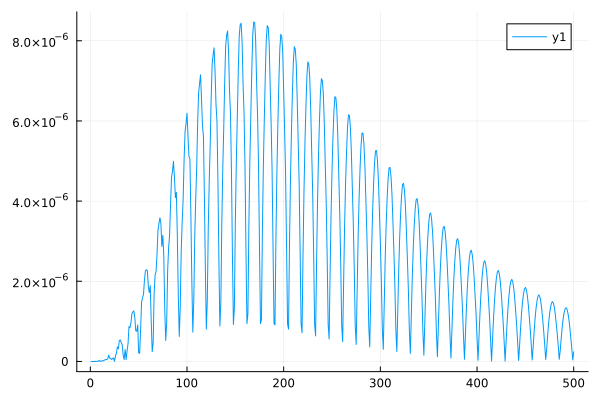

In [11]:
e2 = x_vals_plot - sol2[2,:]
plot(abs.(e2))

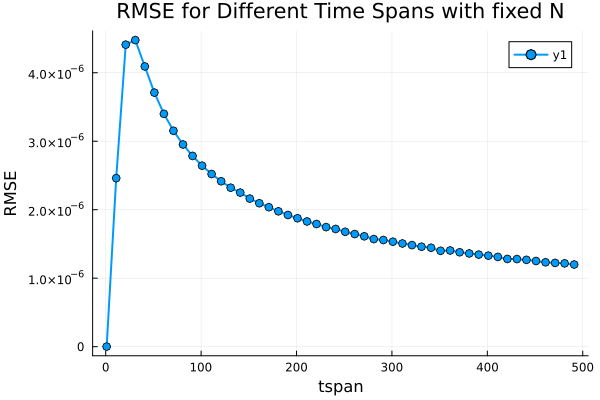

In [12]:
timeSpans = range(1,500,step = 10)
errors = Float64[]

for ts in timeSpans
    tspan = (0.0, ts)
    t_domain = range(0,stop = ts, length = 500)
    prob = SecondOrderODEProblem(mass_damper2!, du0, u0, tspan, p)
    sol = solve(prob, Vern9(), saveat=t_domain)

    x_vals_analytical = [x_numeric(ti) for ti in t_domain]

    x_vals_numerical = sol[2,:]

    rmse = sqrt(sum((x_vals_analytical-x_vals_numerical).^2)/500)
    push!(errors, rmse)
end
plot(timeSpans, errors, xlabel="tspan", ylabel="RMSE", title="RMSE for Different Time Spans with fixed N", lw=2, marker=:o)


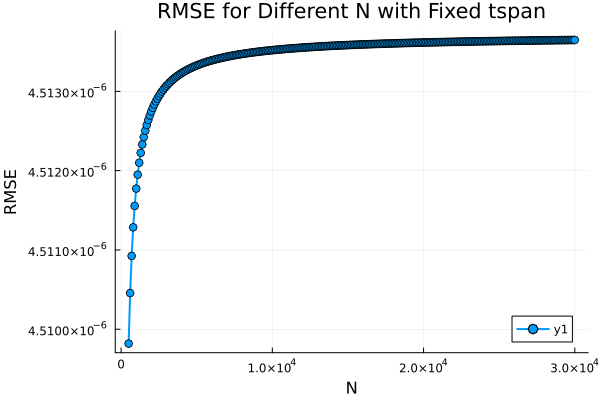

In [15]:
Nvals = range(500, 30000, step=100)
errors = Float64[]

for N in Nvals
    tspan = (0.0, 30.0)
    t_domain = range(0, stop=30, length=N)
    prob = SecondOrderODEProblem(mass_damper2!, du0, u0, tspan, p)
    sol = solve(prob, Vern9(), saveat=t_domain)

    x_vals_analytical = [x_numeric(ti) for ti in t_domain]

    x_vals_numerical = sol[2,:]

    rmse = sqrt(sum((x_vals_analytical .- x_vals_numerical).^2) / N)
    push!(errors, rmse)
end

plot(Nvals, errors, xlabel="N", ylabel="RMSE", title="RMSE for Different N with Fixed tspan", lw=2, marker=:o)